In [1]:
%reload_ext autoreload
%autoreload 2

# Misc.
from tqdm.auto import tqdm

# NumPy
import numpy as np

# torch
import torch
from torch.optim import lr_scheduler
from torch.autograd import grad

# user-defined libs.
from src.problems.solver import PDESolver
from src.utils.plotting import Artist
from src.utils import seed_everything
from src.utils.pde_utils import make_mesh
from src import models

# Reproducibility
seed_everything()
# Set Device(CPU / GPU)
torch.set_float32_matmul_precision('high')
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'torch is using {torch.cuda.get_device_name(device)}')
# Metadata
log_dir = 'logs'
task = 'burgers'

torch is using NVIDIA RTX A4000


In [2]:
def loss_fn(model, x, t, target, criterion):
    return criterion(model(x,t), target)

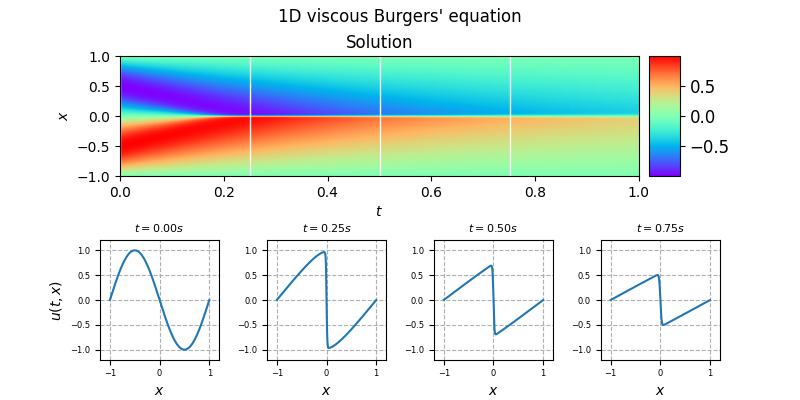

In [3]:
# Parameters
nu = 0.01 / torch.pi
xrange = (-1, 1)
trange = (0, 1)

# Create an instance of ODESolver
# Problem: (Damped) Simple Harmonic Oscillator
solver = PDESolver(
    equation="burgers",
    params=(max(trange) - min(trange), nu),
    xrange=xrange,
    trange=trange,
    Nx=1024,
    Nt=512,
)

# Define an example initial condition
initial_condition = lambda x: -torch.sin(torch.pi * x)

# Solve the ODE using solve_ivp
solution = solver.solve_ivp(initial_condition, True)

solution = solution
xs = solver.xs
ts = solver.ts


artist = Artist()
artist.plot_pde(ts, xs, solution, figsize=(8, 4))
artist.show()

## Pure MLP

In [27]:
model = models.MLP_PINN(
    input_dim=2,
    hidden_dim=20,
    output_dim=1,
    num_layers=8,
    activation="gelu",
    linear_output=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=5,
    threshold=1e-4,
)
criterion = torch.nn.MSELoss()

xx, tt = make_mesh(solver.xs, solver.ts)

# Train data
train_x = convert(xx)
train_t = convert(tt)
train_target = convert(solution)

# Test data
test_x = convert(xx)
test_t = convert(tt)
test_target = torch.Tensor(solution)

total_step = 1_000
plot_interval = 10
model_name = "DNN"
model_log = f"{log_dir}/{model_name}/{task}"

model.train()
for step in tqdm(range(total_step)):
    optimizer.zero_grad()
    loss = loss_fn(model, train_x, train_t, train_target, criterion)
    scheduler.step(loss)
    loss.backward()
    optimizer.step()

    if (step + 1) % plot_interval == 0:
        artist.plot_pde(
            ts,
            xs,
            test_target,
            model(test_x, test_t).view_as(test_target).detach().cpu(),
            f"{model_name} / Training Step: {step+1:04d}, Loss:{loss.item():.3f}",
            figsize=None,
        )
        artist.save_img(f"step_{step+1:05d}", f"{model_log}/imgs")
artist.save_gif_from_files(f"{model_name}-{task}", model_log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Physics-Informed Neural Networks

In [31]:
model = models.MLP_PINN(
    input_dim=2,
    hidden_dim=20,
    output_dim=1,
    num_layers=8,
    activation="gelu",
    linear_output=True,
).to(device)
adam = torch.optim.Adam(model.parameters(), lr=1e-4)
lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50_000,
    max_eval=50_000,
    history_size=50,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe",
)
criterion = torch.nn.MSELoss()

xx, tt = make_mesh(xs, ts)


# Train data
train_x = convert(xx)
train_t = convert(tt)
train_target = convert(solution)

# Test data
test_x = convert(xx)
test_t = convert(tt)
test_target = torch.Tensor(solution)


# 1. Initial Condition
ic_x, ic_t = make_mesh(xs, ts[:1])
ic_x = convert(ic_x)
ic_t = convert(ic_t)
ic_target = convert(initial_condition(ic_x))

# 2. Boundary Condition
lbc_t, lbc_x = make_mesh(ts, xs[:1])
lbc_x = convert(lbc_x)
lbc_t = convert(lbc_t)
rbc_t, rbc_x = make_mesh(ts, xs[:1])
rbc_x = convert(rbc_x)
rbc_t = convert(rbc_t)

# 3. Collocation Data
collocation_x = convert(xx)
collocation_t = convert(tt)


def pinn_loss(model, x, t, weight: float = 1):
    # PDE Loss
    # u_t + uu_x = \nu u_xx
    x = x.requires_grad_()
    t = t.requires_grad_()
    u = model(x, t)
    grad_kwds = dict(grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)

    u_t = grad(u, t, **grad_kwds)[0]
    u_x = grad(u, x, **grad_kwds)[0]
    u_xx = grad(u_x, x, **grad_kwds)[0]
    return weight * criterion(u_t + u * u_x, nu * u_xx)


def closure():
    lbfgs.zero_grad()
    # data-driven loss
    loss_d = loss_fn(model, train_x, train_t, train_target, criterion)
    # IC Loss
    loss_ic = loss_fn(model, ic_x, ic_t, ic_target, criterion)
    # BC Loss
    loss_bc = loss_fn(model, lbc_x, lbc_t, model(lbc_x, lbc_t), criterion)
    # pinn loss
    loss_g = pinn_loss(model, collocation_x, collocation_t)
    # total loss
    loss = loss_d + loss_ic + loss_bc + loss_g
    loss.backward()
    return loss


total_step = 10_000
plot_interval = 100
model_name = "PINN"
model_log = f"{log_dir}/{model_name}/{task}"

model.train()
for step in tqdm(range(total_step)):
    adam.zero_grad()
    # data-driven loss
    loss_d = loss_fn(model, train_x, train_t, train_target, criterion)
    # IC Loss
    loss_ic = loss_fn(model, ic_x, ic_t, ic_target, criterion)
    # BC Loss
    loss_bc = loss_fn(model, lbc_x, lbc_t, model(lbc_x, lbc_t), criterion)
    # pinn loss
    loss_g = pinn_loss(model, collocation_x, collocation_t)
    # total loss
    loss = loss_d + loss_ic + loss_bc + loss_g
    loss.backward()
    adam.step()

    if (step + 1) == int(total_step * 0.90):
        lbfgs.step(closure)

    if (step + 1) % plot_interval == 0:
        artist.plot_pde(
            ts,
            xs,
            test_target,
            model(test_x, test_t).view_as(test_target).detach().cpu(),
            f"{model_name} / Training Step: {step+1:04d}, Loss:{loss.item():.3f}",
            figsize=None,
        )
        artist.save_img(f"step_{step+1:05d}", f"{model_log}/imgs")
artist.save_gif_from_files(f"{model_name}-{task}", model_log)

  0%|          | 0/10000 [00:00<?, ?it/s]